# Complete Flight Analysis

In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from sqlalchemy import create_engine
from sqlalchemy.types import (
    Date, DateTime, Float, Integer, String, Interval, Time
    )

### Import raw Airline Data

In [ ]:
# Select relevant Columns

col_list = [
    'Flight_Number_Operating_Airline',
    'Operating_Airline ',
    'FlightDate',
    'Origin',
    'OriginCityName',
    'CRSDepTime',
    'DepTime', 
    'Dest',
    'DestCityName',
    'CRSArrTime',
    'ArrTime',
    'ArrDelayMinutes',
    'DepDelayMinutes',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay',
    'Cancelled',
    'CancellationCode'
    ]

In [ ]:
# Create blank master DF

messy_flight_df = pd.DataFrame()

In [ ]:
# import full year into DF

twenty18 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2018_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty18 = pd.concat([twenty18,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty18=twenty18[col_list]

In [ ]:
# # Create a checkpoint
# twenty18.to_csv('Resources/2018_raw.csv')

In [ ]:
# import full year into DF

twenty19 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2019_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty19 = pd.concat([twenty19,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty19=twenty19[col_list]

In [ ]:
# # Create a checkpoint
# twenty19.to_csv('Resources/2019_raw.csv')

In [ ]:
# import full year into DF

twenty20 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2020_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty20 = pd.concat([twenty20,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty20=twenty20[col_list]

In [ ]:
# # Create a checkpoint

# twenty20.to_csv('Resources/2020_raw.csv')

In [ ]:
# import full year into DF

twenty21 = pd.DataFrame()
for j in range(1,13):
    file = Path(f'../archive/raw/Flights_2021_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')
    twenty21 = pd.concat([twenty21,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty21=twenty21[col_list]

In [ ]:
# # Create a checkpoint
# twenty21.to_csv('Resources/2021_raw.csv')

In [ ]:
# import full year into DF

twenty22 = pd.DataFrame()
for j in range(1,8):
    file = Path(f'../archive/raw/Flights_2022_{j}.csv')
    import_df = pd.read_csv(file,low_memory=False,engine='c')    
    twenty22 = pd.concat([twenty22,import_df],ignore_index=True)

In [ ]:
# narrow DF down to relevant columns
twenty22=twenty22[col_list]

In [ ]:
# # Create a checkpoint
# twenty22.to_csv('Resources/2022_raw.csv')

In [ ]:
# Combine all years into one DF

messy_flight_df = pd.concat([twenty18,twenty19,twenty20,twenty21,twenty22],axis=0)

##### Create Target and Classifier columns

In [ ]:
# Making new binary column that tracks delay for both arr and dep

arr_dep_delayed = (messy_flight_df['ArrDelayMinutes']>0) | (messy_flight_df['DepDelayMinutes']>0)

messy_flight_df['Delayed'] = np.where(arr_dep_delayed, 1, 0)

In [ ]:
# Creates an integer coded target column for the Machine learning model 

on_time = (messy_flight_df['Delayed']==0) & (messy_flight_df['Cancelled']==0)
delayed = messy_flight_df['Delayed']==1
cancelled = messy_flight_df['Cancelled']==1

messy_flight_df['Target'] = np.where(on_time, '0', np.where(delayed,'1', np.where(cancelled,'2','')))

In [ ]:
# Function to clean the values in certain columns to a readable military datetime format

def mil_time_converter (series):
    # converts the string into a military time format
    series = series.apply(lambda x: f'{(int(x) // 100):02d}:{(int(x) % 100):02d}' if pd.notnull(x) else x)
    # Convert string to correct midnight format
    series = series.apply(lambda x: '00:00' if x == '24:00' else x)
    # Converts values into datetime object
    series = series.apply(lambda x: pd.to_datetime(x,format='%H:%M').strftime('%H:%M') if pd.notnull(x) else x)
    return series

# have not run this for production but should be faster
def mil_time_converter_faster (series):
    return series.apply(lambda x: pd.to_datetime(f'{(int(x) // 100):02d}:{(int(x) % 100):02d}', format='%H:%M')
        .replace(hour=0) if x == '2400' else pd.to_datetime(f'{(int(x) // 100):02d}:{(int(x) % 100):02d}', format='%H:%M') 
        if pd.notnull(x) else x)

In [ ]:
# Convert Arrival and Departure times to military format
mil_time_cols = ['ArrTime','CRSArrTime','DepTime','CRSDepTime']

for col in mil_time_cols:
    messy_flight_df[col]=mil_time_converter(messy_flight_df[col])

In [ ]:
# Convert FlightDate to datetime object

messy_flight_df['FlightDate'] = messy_flight_df['FlightDate'].apply(lambda x: pd.to_datetime(x) if pd.notnull(x) else x)

In [ ]:
# Create checkpoint

messy_flight_df.to_csv('Resources/checkpoint.csv')

In [3]:
# load checkpoint
messy_flight_df = pd.read_csv('Resources/checkpoint.csv')

/Applications/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
messy_flight_df

,Unnamed: 0,Flight_Number_Operating_Airline,Operating_Airline,FlightDate,Origin,OriginCityName,CRSDepTime,DepTime,Dest,DestCityName,...,DepDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Delayed,Target
0,0,3298,9E,2018-01-23,ABY,"Albany, GA",12:02,11:57,ATL,"Atlanta, GA",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
1,1,3298,9E,2018-01-24,ABY,"Albany, GA",12:02,11:57,ATL,"Atlanta, GA",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
2,2,3298,9E,2018-01-25,ABY,"Albany, GA",12:02,11:53,ATL,"Atlanta, GA",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
3,3,3298,9E,2018-01-26,ABY,"Albany, GA",12:02,11:50,ATL,"Atlanta, GA",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
4,4,3298,9E,2018-01-27,ABY,"Albany, GA",14:00,13:55,ATL,"Atlanta, GA",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29193777,4078313,3406,YX,2022-07-01,ALB,"Albany, NY",15:00,15:16,EWR,"Newark, NJ",...,16.0,0.0,0.0,18.0,0.0,0.0,0.0,NaN,1,1
29193778,4078314,3405,YX,2022-07-01,AVL,"Asheville, NC",12:46,12:36,EWR,"Newark, NJ",...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
29193779,4078315,3403,YX,2022-07-01,ALB,"Albany, NY",12:01,11:53,EWR,"Newark, NJ",...,0.0,0.0,0.0,20.0,0.0,0.0,0.0,NaN,1,1
29193780,4078316,3401,YX,2022-07-01,BNA,"Nashville, TN",14:30,14:58,EWR,"Newark, NJ",...,28.0,0.0,0.0,43.0,0.0,0.0,0.0,NaN,1,1


In [4]:
# Split the city and State
messy_flight_df[['Destination_City','Destination_State']] = messy_flight_df['DestCityName'].str.split(', ',expand=True)
messy_flight_df[['Origin_City','Origin_State']] = messy_flight_df['OriginCityName'].str.split(', ',expand=True)
# Remove unnecesary Column
messy_flight_df = messy_flight_df.drop(columns=['DestCityName'])
messy_flight_df = messy_flight_df.drop(columns=['OriginCityName'])

In [5]:
# create a flight index
messy_flight_df['Flight_Index'] = messy_flight_df.index

In [6]:
# import airlines csv from resources to add Airline Names to Flights Table

airlines_df_path = Path('Resources/Airlines.csv')
airlines_df = pd.read_csv(airlines_df_path)

In [7]:
# add airline names to flights table
messy_flight_df = messy_flight_df.merge(airlines_df, left_on='Operating_Airline ', right_on='Code')

In [9]:
# rename columns
messy_flight_df.columns = ['Flight_Year_Index', 'Flight_Number', 'Airline_Code',
       'Flight_Date', 'Dep_Airport', 'Scheduled_Dep_Time', 'Dep_Time', 'Arr_Airport', 'Scheduled_Arr_Time',
       'Arr_Time', 'Arr_Delay', 'Dep_Delay', 'Carrier_Delay',
       'Weather_Delay', 'NAS_Delay', 'Security_Delay', 'Late_Aircraft_Delay',
       'Cancelled', 'Cancellation_Code', 'Delayed', 'Target',
       'Arr_City', 'Arr_State', 'Dep_City', 'Dep_State',
       'Flight_Index', 'Code', 'Airline_Name']

#### Export combined data csv

In [11]:
# Export table into csv with relevant columns in order 

messy_flight_df[[
   'Flight_Index',
   'Flight_Year_Index',
   'Flight_Number',
   'Airline_Code',
   'Airline_Name',
   'Flight_Date',
   'Scheduled_Dep_Time',
   'Dep_Time',
   'Dep_Airport',
   'Dep_City',
   'Dep_State',
   'Scheduled_Arr_Time',
   'Arr_Time',
   'Arr_Airport',
   'Arr_City',
   'Arr_State',
   'Delayed',
   'Arr_Delay',
   'Dep_Delay',
   'Carrier_Delay',
   'Weather_Delay',
   'NAS_Delay',
   'Security_Delay',
   'Late_Aircraft_Delay',
   'Cancelled',
   'Cancellation_Code',
   'Target'
   ]].to_csv('Resources/Complete_Flights.csv')

### Create, Format, and Export Tables for Database

In [12]:
# Either imports if starting from new session or makes a copy of DF for cleaning
try:
    if messy_flight_df is not None:
        Flights_df = messy_flight_df
except NameError:
    # will only run if checkpoint is created
    messy_flight_path = Path('Resources/Complete_Flights.csv')
    Flights_df = pd.read_csv(messy_flight_path)

/Applications/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Delayed Flights Table

In [23]:
# create a list of columns from messy_flight_df to make Delayed Flight DF


delayed_columns_list = [
    'Flight_Index',
    'Flight_Year_Index',
    'Flight_Number',
    'Airline_Code',
    'Airline_Name',
    'Flight_Date',
    'Dep_Airport',
    'Dep_City',
    'Dep_State',
    'Scheduled_Dep_Time',
    'Dep_Time',
    'Arr_Airport',
    'Arr_City',
    'Arr_State',
    'Scheduled_Arr_Time',
    'Arr_Time',
    'Arr_Delay',
    'Dep_Delay',
    'Carrier_Delay',
    'Weather_Delay',
    'NAS_Delay',
    'Security_Delay',
    'Late_Aircraft_Delay'
]

In [24]:
# Create the Delayed Flights DF

delayed = Flights_df['Delayed']==1

Delayed_Flights_df = Flights_df.loc[delayed][delayed_columns_list].copy()

In [25]:
# Export cleaned Dataframe to csv to use as Table

cleaned_delay_path = Path('Resources/Complete_Delayed_Flights.csv')
Delayed_Flights_df.to_csv(cleaned_delay_path)

#### Cancelled Flights Table

In [26]:
# create a list of columns from messy_flight_df to make Cancelled Flights DF

cancelled_flights_list = [
    'Flight_Index',
    'Flight_Year_Index',
    'Flight_Number',
    'Airline_Code',
    'Airline_Name',
    'Flight_Date',
    'Dep_Airport',
    'Dep_City',
    'Dep_State',
    'Scheduled_Dep_Time',
    'Dep_Time',
    'Arr_Airport',
    'Arr_City',
    'Arr_State',
    'Scheduled_Arr_Time',
    'Arr_Time',
    'Cancellation_Code'
]

In [27]:
# Create the Cancelled Flights DF

cancelled = Flights_df['Cancelled']==1

Cancelled_Flights_df = Flights_df.loc[cancelled][cancelled_flights_list].copy()

In [28]:
# Export cleaned Dataframe to csv to use as Table

cancelled_flight_path = Path('Resources/Complete_Cancelled_Flights.csv')
Cancelled_Flights_df.to_csv(cancelled_flight_path)

#### Airlines Table

In [77]:
# import airlines csv from resources

airlines_df_path = Path('Resources/Airlines.csv')
airlines_df = pd.read_csv(airlines_df_path)

In [78]:
airlines_df

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1566,ZW,Air Wisconsin Airlines Corp
1567,ZX,Air Georgian
1568,ZX (1),Airbc Ltd.
1569,ZY,Atlantic Gulf Airlines


In [79]:
# Total Flight Stats

airline_total_count = Flights_df.groupby('Airline_Name').count()['Flight_Index'].to_dict()

In [80]:
# Delay Stats

# Total number of times delayed by airline
airline_delay_count = Delayed_Flights_df.groupby('Airline_Name').count()['Flight_Index'].to_dict()
# Sum of arr/dep delay minutes by airline
airline_arr_delay_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['Arr_Delay'].to_dict()
airline_dep_delay_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['Dep_Delay'].to_dict()

# Total number of Carrier_Delay by airline
airline_carrier_count = Delayed_Flights_df.loc[Delayed_Flights_df['Carrier_Delay']>0].groupby('Airline_Name').count()['Flight_Index'].to_dict()
# sum of Carrier_Delay minutes by airline
airline_carrier_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['Carrier_Delay'].to_dict()

# Total number of Weather_Delay by airline
airline_weather_count = Delayed_Flights_df.loc[Delayed_Flights_df['Weather_Delay']>0].groupby('Airline_Name').count()['Flight_Index'].to_dict()
# sum of Weather_Delay minutes by airline
airline_weather_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['Weather_Delay'].to_dict()

# Total number of NAS_Delay by airline
airline_NAS_count = Delayed_Flights_df.loc[Delayed_Flights_df['NAS_Delay']>0].groupby('Airline_Name').count()['Flight_Index'].to_dict()
# sum of NAS_Delay minutes by airline
airline_NAS_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['NAS_Delay'].to_dict()

# Total number of Security_Delay by airline
airline_security_count = Delayed_Flights_df.loc[Delayed_Flights_df['Security_Delay']>0].groupby('Airline_Name').count()['Flight_Index'].to_dict()
# sum of Security_Delay minutes by airline
airline_security_minutes = Delayed_Flights_df.groupby('Airline_Name').sum()['Security_Delay'].to_dict()

In [81]:
# Cancelled Flight Stats

# Total number of cancels by airline
airline_cancel_count =Cancelled_Flights_df.groupby('Airline_Name').count()['Flight_Index'].to_dict()

# Total number of Carrier Cancels
airline_carrier_cancel =Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='A'].groupby('Airline_Name')['Flight_Index'].count().to_dict()

# Total number of Weather Cancels
airline_weather_cancel =Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='B'].groupby('Airline_Name')['Flight_Index'].count().to_dict()

# Total number of NAS Cancels
airline_NAS_cancel =Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='C'].groupby('Airline_Name')['Flight_Index'].count().to_dict()

# Total number of Security Cancels
airline_security_cancel =Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='D'].groupby('Airline_Name')['Flight_Index'].count().to_dict()


# Could do late aircraft delay based on if the previous flight was the same airline

In [83]:
# Add Totals to airlines table

airlines_df['Total_Flight_Count'] = airlines_df['Description'].map(airline_total_count)
airlines_df['Cancel_Count'] = airlines_df['Description'].map(airline_cancel_count)
airlines_df['Delay_Count'] = airlines_df['Description'].map(airline_delay_count)

airlines_df['Arr_Delay_Sum'] = airlines_df['Description'].map(airline_arr_delay_minutes)
airlines_df['Dep_Delay_Sum'] = airlines_df['Description'].map(airline_dep_delay_minutes)
airlines_df['Total_Delay_Avg'] =(airlines_df['Dep_Delay_Sum']+airlines_df['Arr_Delay_Sum'])/airlines_df['Total_Flight_Count']
airlines_df['Arr_Delay_Avg'] = airlines_df['Arr_Delay_Sum']/airlines_df['Delay_Count']
airlines_df['Dep_Delay_Avg'] = airlines_df['Dep_Delay_Sum']/airlines_df['Delay_Count']


airlines_df['Carrier_Cancel_Count'] = airlines_df['Description'].map(airline_carrier_cancel)
airlines_df['Carrier_Delay_Count'] = airlines_df['Description'].map(airline_carrier_count)

airlines_df['Carrier_Delay_Sum'] = airlines_df['Description'].map(airline_carrier_minutes)
airlines_df['Carrier_Delay_Avg'] = airlines_df['Carrier_Delay_Sum']/airlines_df['Carrier_Delay_Count']


airlines_df['Weather_Cancel_Count'] = airlines_df['Description'].map(airline_weather_cancel)
airlines_df['Weather_Delay_Count'] = airlines_df['Description'].map(airline_weather_count)

airlines_df['Weather_Delay_Sum'] = airlines_df['Description'].map(airline_weather_minutes)
airlines_df['Weather_Delay_Avg'] = airlines_df['Weather_Delay_Sum']/airlines_df['Weather_Delay_Count']


airlines_df['NAS_Cancel_Count'] = airlines_df['Description'].map(airline_NAS_cancel)
airlines_df['NAS_Delay_Count'] = airlines_df['Description'].map(airline_NAS_count)

airlines_df['NAS_Delay_Sum'] = airlines_df['Description'].map(airline_NAS_minutes)
airlines_df['NAS_Delay_Avg'] = airlines_df['NAS_Delay_Sum']/airlines_df['NAS_Delay_Count']


airlines_df['Security_Cancel_Count'] = airlines_df['Description'].map(airline_security_cancel)
airlines_df['Security_Delay_Count'] = airlines_df['Description'].map(airline_security_count)

airlines_df['Security_Delay_Sum'] = airlines_df['Description'].map(airline_security_minutes)
airlines_df['Security_Delay_Avg'] = airlines_df['Security_Delay_Sum']/airlines_df['Security_Delay_Count']


In [84]:
# Rename Columns
airlines_df = airlines_df.rename(columns={'Code':'Airline_Code','Description':'Airline_Name'})

In [101]:
airlines_df

,Airline_Code,Airline_Name,Total_Flight_Count,Cancel_Count,Delay_Count,Arr_Delay_Sum,Dep_Delay_Sum,Total_Delay_Avg,Arr_Delay_Avg,Dep_Delay_Avg,...,Weather_Delay_Sum,Weather_Delay_Avg,NAS_Cancel_Count,NAS_Delay_Count,NAS_Delay_Sum,NAS_Delay_Avg,Security_Cancel_Count,Security_Delay_Count,Security_Delay_Sum,Security_Delay_Avg
0,02Q,Titan Airways,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04Q,Tradewind Aviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,05Q,"Comlux Aviation, AG",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06Q,Master Top Linhas Aereas Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07Q,Flair Airlines Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,ZW,Air Wisconsin Airlines Corp,380202.0,14092.0,125179.0,5836745.0,5583145.0,30.036375,46.62719,44.601291,...,255219.0,53.303885,1524.0,35768.0,1148359.0,32.105765,3115.0,4.0,266.0,66.5
1567,ZX,Air Georgian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,ZX (1),Airbc Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1569,ZY,Atlantic Gulf Airlines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Export cleaned Dataframe to csv to use as Table

cleaned_airlines_path = Path('Resources/Complete_Airlines.csv')
airlines_df.to_csv(cleaned_airlines_path)

#### Airport Codes Table

In [87]:
# create a list of columns from messy_flight_df to make Airport Codes DF

airport_codes_list = [
    'Dep_Airport',
    'Dep_City',
    'Dep_State'
]

In [88]:
# Create the Airport Codes DF

airports_df = Flights_df[airport_codes_list].copy()

In [89]:
# get only the Unique Origin Airport Codes
airports_df = airports_df.drop_duplicates(subset=['Dep_Airport'])

In [90]:
# Clean the index

airports_df.reset_index(drop=True,inplace=True)

In [91]:
# rename columns
airports_df = airports_df.rename(columns={
    'Dep_Airport':'Airport_Code',
    'Dep_City':'Airport_City',
    'Dep_State':'Airport_State'})

In [92]:
airports_df

,Airport_Code,Airport_City,Airport_State
0,ABY,Albany,GA
1,ATL,Atlanta,GA
2,MOB,Mobile,AL
3,BUF,Buffalo,NY
4,DFW,Dallas/Fort Worth,TX
...,...,...,...
383,GCK,Garden City,KS
384,DBQ,Dubuque,IA
385,SPS,Wichita Falls,TX
386,SWO,Stillwater,OK


In [93]:
arr_airport_total_count = Flights_df.groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_total_count = Flights_df.groupby('Dep_Airport').count()['Flight_Index'].to_dict()

In [94]:
# Delayed FLight Data

# Sum of arrival/departure minutes waited
arr_airport_delay_minutes= Delayed_Flights_df.groupby('Arr_Airport').sum()['Arr_Delay'].to_dict()
dep_airport_delay_minutes= Delayed_Flights_df.groupby('Dep_Airport').sum()['Dep_Delay'].to_dict()
# Total # of times arrival/departure delays count
arr_airport_delay_count = Delayed_Flights_df.loc[Delayed_Flights_df['Arr_Delay']>0].groupby('Arr_Airport').count()['Arr_Delay'].to_dict()
dep_airport_delay_count = Delayed_Flights_df.loc[Delayed_Flights_df['Dep_Delay']>0].groupby('Dep_Airport').count()['Dep_Delay'].to_dict()

# Sum of Carrier minutes waited
arr_airport_carrier_minutes = Delayed_Flights_df.groupby('Arr_Airport').sum()['Carrier_Delay'].to_dict()
dep_airport_carrier_minutes = Delayed_Flights_df.groupby('Dep_Airport').sum()['Carrier_Delay'].to_dict()
# Total # of times carrier arrival/departure delays occurred
arr_airport_carrier_count = Delayed_Flights_df.loc[Delayed_Flights_df['Carrier_Delay']>0].groupby('Arr_Airport').count()['Carrier_Delay'].to_dict()
dep_airport_carrier_count = Delayed_Flights_df.loc[Delayed_Flights_df['Carrier_Delay']>0].groupby('Dep_Airport').count()['Carrier_Delay'].to_dict()

# Sum of Weather minutes waited
arr_airport_weather_minutes = Delayed_Flights_df.groupby('Arr_Airport').sum()['Weather_Delay'].to_dict()
dep_airport_weather_minutes = Delayed_Flights_df.groupby('Dep_Airport').sum()['Weather_Delay'].to_dict()
# Total # of times Weather arrival/departure delays occurred
arr_airport_weather_count = Delayed_Flights_df.loc[Delayed_Flights_df['Weather_Delay']>0].groupby('Arr_Airport').count()['Weather_Delay'].to_dict()
dep_airport_weather_count = Delayed_Flights_df.loc[Delayed_Flights_df['Weather_Delay']>0].groupby('Dep_Airport').count()['Weather_Delay'].to_dict()

# Sum of Nas minutes waited
arr_airport_NAS_minutes = Delayed_Flights_df.groupby('Arr_Airport').sum()['NAS_Delay'].to_dict()
dep_airport_NAS_minutes = Delayed_Flights_df.groupby('Dep_Airport').sum()['NAS_Delay'].to_dict()
# Total # of times NAS arrival/departure delays occurred
arr_airport_NAS_count = Delayed_Flights_df.loc[Delayed_Flights_df['NAS_Delay']>0].groupby('Arr_Airport').count()['NAS_Delay'].to_dict()
dep_airport_NAS_count = Delayed_Flights_df.loc[Delayed_Flights_df['NAS_Delay']>0].groupby('Dep_Airport').count()['NAS_Delay'].to_dict()

# Sum of Security minutes waited
arr_airport_security_minutes = Delayed_Flights_df.groupby('Arr_Airport').sum()['Security_Delay'].to_dict()
dep_airport_security_minutes = Delayed_Flights_df.groupby('Dep_Airport').sum()['Security_Delay'].to_dict()
# Total # of times Security arrival/departure delays occurred
arr_airport_security_count = Delayed_Flights_df.loc[Delayed_Flights_df['Security_Delay']>0].groupby('Arr_Airport').count()['Security_Delay'].to_dict()
dep_airport_security_count = Delayed_Flights_df.loc[Delayed_Flights_df['Security_Delay']>0].groupby('Dep_Airport').count()['Security_Delay'].to_dict()

In [95]:
# Cancelled Stats

# Total # of Cancels as arrival/Departure airport
arr_airport_cancel_count= Cancelled_Flights_df.groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_cancel_count= Cancelled_Flights_df.groupby('Dep_Airport').count()['Flight_Index'].to_dict()

# Total # of times carrier arrival/departure cancel occurred
arr_airport_carrier_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='A'].groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_carrier_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='A'].groupby('Dep_Airport').count()['Flight_Index'].to_dict()

# Total # of times Weather arrival/departure cancel occurred
arr_airport_weather_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='B'].groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_weather_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='B'].groupby('Dep_Airport').count()['Flight_Index'].to_dict()

# Total # of times NAS arrival/departure cancel occurred
arr_airport_NAS_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='C'].groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_NAS_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='C'].groupby('Dep_Airport').count()['Flight_Index'].to_dict()

# Total # of times Security arrival/departure cancels occurred
arr_airport_security_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='D'].groupby('Arr_Airport').count()['Flight_Index'].to_dict()
dep_airport_security_cancel = Cancelled_Flights_df.loc[Cancelled_Flights_df['Cancellation_Code']=='D'].groupby('Dep_Airport').count()['Flight_Index'].to_dict()



In [98]:
# Add totals to airports table

airports_df['Arr_Total_Count']= airports_df['Airport_Code'].map(arr_airport_total_count)
airports_df['Dep_Total_Count']= airports_df['Airport_Code'].map(dep_airport_total_count)

airports_df['Arr_Cancel_Count']= airports_df['Airport_Code'].map(arr_airport_cancel_count)
airports_df['Dep_Cancel_Count']= airports_df['Airport_Code'].map(dep_airport_cancel_count)
airports_df['Arr_Delay_Count']= airports_df['Airport_Code'].map(arr_airport_delay_count)
airports_df['Dep_Delay_Count']= airports_df['Airport_Code'].map(dep_airport_delay_count)

airports_df['Arr_Delay_Sum']= airports_df['Airport_Code'].map(arr_airport_delay_minutes)
airports_df['Dep_Delay_Sum']= airports_df['Airport_Code'].map(dep_airport_delay_minutes)
airports_df['Arr_Delay_Avg'] =airports_df['Arr_Delay_Sum']/airports_df['Arr_Delay_Count']
airports_df['Dep_Delay_Avg'] =airports_df['Dep_Delay_Sum']/airports_df['Dep_Delay_Count']
airports_df['Total_Delay_Avg'] =(airports_df['Dep_Delay_Sum']+airports_df['Arr_Delay_Sum'])/(airports_df['Arr_Delay_Count'] + airports_df['Arr_Delay_Count'])

airports_df['Arr_Carrier_Cancel']= airports_df['Airport_Code'].map(arr_airport_carrier_cancel)
airports_df['Dep_Carrier_Cancel']= airports_df['Airport_Code'].map(dep_airport_carrier_cancel)
airports_df['Arr_Carrier_Delay']= airports_df['Airport_Code'].map(arr_airport_carrier_count)
airports_df['Dep_Carrier_Delay']= airports_df['Airport_Code'].map(dep_airport_carrier_count)

airports_df['Arr_Carrier_Sum']= airports_df['Airport_Code'].map(arr_airport_carrier_minutes)
airports_df['Dep_Carrier_Sum']= airports_df['Airport_Code'].map(dep_airport_carrier_minutes)
airports_df['Arr_Carrier_Avg'] =airports_df['Arr_Carrier_Sum']/airports_df['Arr_Carrier_Delay']
airports_df['Dep_Carrier_Avg'] =airports_df['Dep_Carrier_Sum']/airports_df['Dep_Carrier_Delay']
airports_df['Total_Carrier_Avg'] =(airports_df['Arr_Carrier_Sum']+airports_df['Dep_Carrier_Sum'])/(airports_df['Arr_Carrier_Delay'] + airports_df['Dep_Carrier_Delay'])


airports_df['Arr_Weather_Cancel']= airports_df['Airport_Code'].map(arr_airport_weather_cancel)
airports_df['Dep_Weather_Cancel']= airports_df['Airport_Code'].map(dep_airport_weather_cancel)
airports_df['Arr_Weather_Delay']= airports_df['Airport_Code'].map(arr_airport_weather_count)
airports_df['Dep_Weather_Delay']= airports_df['Airport_Code'].map(dep_airport_weather_count)

airports_df['Arr_Weather_Sum']= airports_df['Airport_Code'].map(arr_airport_weather_minutes)
airports_df['Dep_Weather_Sum']= airports_df['Airport_Code'].map(dep_airport_weather_minutes)
airports_df['Arr_Weather_Avg'] =airports_df['Arr_Weather_Sum']/airports_df['Arr_Weather_Delay']
airports_df['Dep_Weather_Avg'] =airports_df['Dep_Weather_Sum']/airports_df['Dep_Weather_Delay']
airports_df['Total_Weather_Avg'] =(airports_df['Arr_Weather_Sum']+airports_df['Dep_Weather_Sum'])/(airports_df['Arr_Weather_Delay'] + airports_df['Dep_Weather_Delay'])


airports_df['Arr_NAS_Cancel']= airports_df['Airport_Code'].map(arr_airport_NAS_cancel)
airports_df['Dep_NAS_Cancel']= airports_df['Airport_Code'].map(dep_airport_NAS_cancel)
airports_df['Arr_NAS_Delay']= airports_df['Airport_Code'].map(arr_airport_NAS_count)
airports_df['Dep_NAS_Delay']= airports_df['Airport_Code'].map(dep_airport_NAS_count)

airports_df['Arr_NAS_Sum']= airports_df['Airport_Code'].map(arr_airport_NAS_minutes)
airports_df['Dep_NAS_Sum']= airports_df['Airport_Code'].map(dep_airport_NAS_minutes)
airports_df['Arr_NAS_Avg'] =airports_df['Arr_NAS_Sum']/airports_df['Arr_NAS_Delay']
airports_df['Dep_NAS_Avg'] =airports_df['Dep_NAS_Sum']/airports_df['Dep_NAS_Delay']
airports_df['Total_NAS_Avg'] =(airports_df['Arr_NAS_Sum']+airports_df['Dep_NAS_Sum'])/(airports_df['Arr_NAS_Delay'] + airports_df['Dep_NAS_Delay'])


airports_df['Arr_Security_Cancel']= airports_df['Airport_Code'].map(arr_airport_security_cancel)
airports_df['Dep_Security_Cancel']= airports_df['Airport_Code'].map(dep_airport_security_cancel)
airports_df['Arr_Security_Delay']= airports_df['Airport_Code'].map(arr_airport_security_count)
airports_df['Dep_Security_Delay']= airports_df['Airport_Code'].map(dep_airport_security_count)

airports_df['Arr_Security_Sum']= airports_df['Airport_Code'].map(arr_airport_security_minutes)
airports_df['Dep_Security_Sum']= airports_df['Airport_Code'].map(dep_airport_security_minutes)
airports_df['Arr_Security_Avg'] =airports_df['Arr_Security_Sum']/airports_df['Arr_Security_Delay']
airports_df['Dep_Security_Avg'] =airports_df['Dep_Security_Sum']/airports_df['Dep_Security_Delay']
airports_df['Total_Security_Avg'] =(airports_df['Arr_Security_Sum']+airports_df['Dep_Security_Sum'])/(airports_df['Arr_Security_Delay'] + airports_df['Dep_Security_Delay'])


In [99]:
airports_df

,Airport_Code,Airport_City,Airport_State,Arr_Total_Count,Dep_Total_Count,Arr_Cancel_Count,Dep_Cancel_Count,Arr_Delay_Count,Dep_Delay_Count,Arr_Delay_Sum,...,Dep_Security_Delay,Arr_Security_Sum,Dep_Security_Sum,Arr_Security_Avg,Dep_Security_Avg,Total_Delay_Avg,Total_Carrier_Avg,Total_Weather_Avg,Total_NAS_Avg,Total_Security_Avg
0,ABY,Albany,GA,3884,3884,36.0,37.0,955,696,37037.0,...,1.0,14.0,28.0,14.000000,28.000000,41.397906,82.941799,87.915254,21.925676,21.000000
1,ATL,Atlanta,GA,1371789,1371796,22034.0,21710.0,353208,431582,13196243.0,...,652.0,23049.0,27821.0,37.417208,42.670245,37.630677,46.039677,62.476967,26.109510,40.118297
2,MOB,Mobile,AL,23511,23510,614.0,652.0,7515,5583,288949.0,...,13.0,119.0,178.0,29.750000,13.692308,39.685496,53.562986,77.096814,23.626924,17.470588
3,BUF,Buffalo,NY,95349,95342,3566.0,3742.0,31552,26199,1323411.0,...,24.0,2219.0,737.0,36.377049,30.708333,41.197008,42.495277,66.173123,29.890445,34.776471
4,DFW,Dallas/Fort Worth,TX,1104182,1104266,37683.0,36698.0,373561,381306,16603563.0,...,705.0,25371.0,19096.0,22.274802,27.086525,42.712467,45.039666,61.186877,26.838865,24.114425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,GCK,Garden City,KS,2835,2833,94.0,103.0,789,668,23985.0,...,2.0,60.0,16.0,60.000000,8.000000,35.799747,39.026627,83.944444,21.408879,25.333333
384,DBQ,Dubuque,IA,2917,2916,124.0,131.0,992,552,34978.0,...,NaN,0.0,0.0,NaN,NaN,32.727319,37.257143,61.436709,24.699336,NaN
385,SPS,Wichita Falls,TX,4447,4442,225.0,224.0,1284,965,31394.0,...,4.0,38.0,67.0,38.000000,16.750000,28.555296,40.492239,65.593750,20.450392,21.000000
386,SWO,Stillwater,OK,2781,2777,89.0,91.0,721,440,20064.0,...,2.0,0.0,30.0,NaN,15.000000,32.271845,53.715415,67.752381,23.565217,NaN


In [100]:
# Export cleaned Dataframe to csv to use as Table

cleaned_airport_table_path = Path('Resources/Complete_Airports.csv')
airports_df.to_csv(cleaned_airport_table_path)

### Load to DB

### Prep for Model

In [3]:
### USE IF CHECKPOINT WAS CREATED

# Loads the Complete Flights csv

ml_df = pd.read_csv('Resources/Complete_Flights.csv')

/Applications/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
ml_df.columns

Index(['Unnamed: 0', 'Flight_Index', 'Flight_Year_Index', 'Flight_Number',
       'Airline_Code', 'Airline_Name', 'Flight_Date', 'Scheduled_Dep_Time',
       'Dep_Time', 'Dep_Airport', 'Dep_City', 'Dep_State',
       'Scheduled_Arr_Time', 'Arr_Time', 'Arr_Airport', 'Arr_City',
       'Arr_State', 'Delayed', 'Arr_Delay', 'Dep_Delay', 'Carrier_Delay',
       'Weather_Delay', 'NAS_Delay', 'Security_Delay', 'Late_Aircraft_Delay',
       'Cancelled', 'Cancellation_Code', 'Target'],
      dtype='object')

In [6]:
ml_df = ml_df.drop(columns=['Unnamed: 0', 'Flight_Index', 'Flight_Year_Index', 'Flight_Number','Airline_Code','Arr_Time','Dep_Time','Delayed','Arr_Delay', 'Dep_Delay','Cancelled', 'Cancellation_Code'])

In [7]:
# split the Date into separate pieces 
ml_df['Flight_Date'] =pd.to_datetime(ml_df['Flight_Date'])
ml_df['Year'] = ml_df['Flight_Date'].dt.year
ml_df['Month'] = ml_df['Flight_Date'].dt.month
ml_df['Day'] = ml_df['Flight_Date'].dt.day
ml_df['Weekday'] = ml_df['Flight_Date'].dt.dayofweek

In [8]:
ml_df = ml_df.drop(columns='Flight_Date')

In [9]:
ml_df[['Arr_Sched_Hour','Arr_Sched_Minute']] = ml_df['Scheduled_Arr_Time'].str.split(':',expand=True)

In [10]:
ml_df = ml_df.drop(columns=['Scheduled_Arr_Time','Arr_Sched_Minute'])

In [11]:
ml_df[['Dep_Sched_Hour','Dep_Sched_Minute']] = ml_df['Scheduled_Dep_Time'].str.split(':',expand=True)

In [13]:
ml_df = ml_df.drop(columns=['Scheduled_Dep_Time','Dep_Sched_Minute'])

In [17]:
# Make columns that track reasons for both delays and cancellations to a binary

def check_condition(delay_col):
    
    condition = (ml_df[delay_col] > 0)
    
    return condition

carrier = check_condition('Carrier_Delay')
bad_weather = check_condition('Weather_Delay')
NAS = check_condition('NAS_Delay')
security = check_condition('Security_Delay')
late_aircraft = (ml_df['Late_Aircraft_Delay'] > 0)

ml_df['Carrier_Issue'] = np.where(carrier, 1, 0)
ml_df['Bad_Weather'] = np.where(bad_weather, 1, 0)
ml_df['NAS'] = np.where(NAS, 1, 0)
ml_df['Security_Issue'] = np.where(security, 1, 0)
ml_df['Late_Aircraft'] = np.where(late_aircraft, 1, 0)

In [19]:
ml_df = ml_df.drop(columns=['Carrier_Delay', 'Weather_Delay', 'NAS_Delay', 'Security_Delay', 'Late_Aircraft_Delay'])

In [20]:
def encoder (df,col,col2=None):
    enc_dict = dict(zip(df[col].unique(),range(len(df[col].unique()))))
    df[col] = df[col].map(enc_dict)
    if col2 is not None:
        df[col2] = df[col2].map(enc_dict)

In [21]:
# decide which columns need encoding

ml_df.columns

Index(['Airline_Name', 'Dep_Airport', 'Dep_City', 'Dep_State', 'Arr_Airport',
       'Arr_City', 'Arr_State', 'Target', 'Year', 'Month', 'Day', 'Weekday',
       'Arr_Sched_Hour', 'Dep_Sched_Hour', 'Carrier_Issue', 'Bad_Weather',
       'NAS', 'Security_Issue', 'Late_Aircraft'],
      dtype='object')

In [22]:
encoder(ml_df,'Airline_Name')

In [23]:
encoder(ml_df,'Dep_Airport',col2='Arr_Airport')

In [24]:
encoder(ml_df,'Dep_City',col2='Arr_City')

In [25]:
encoder(ml_df,'Dep_State',col2='Arr_State')

In [26]:
ml_df.columns

Index(['Airline_Name', 'Dep_Airport', 'Dep_City', 'Dep_State', 'Arr_Airport',
       'Arr_City', 'Arr_State', 'Target', 'Year', 'Month', 'Day', 'Weekday',
       'Arr_Sched_Hour', 'Dep_Sched_Hour', 'Carrier_Issue', 'Bad_Weather',
       'NAS', 'Security_Issue', 'Late_Aircraft'],
      dtype='object')

In [27]:
# Fill NaN values for the Model
ml_df = ml_df.fillna(0)

In [28]:
# Export the Model Ready csv

ml_df.to_csv('Resources/Complete_ML_Table.csv')

### Model Execution

In [2]:
# Import client from dask
from dask.distributed import Client

# Import pandas
import pandas as pd

# Import necessary functions for machine learning models
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

In [3]:
# Start a client

client = Client()

In [4]:
# Import dask dataframe

brf_df = dd.read_csv('Resources/Complete_ML_Table.csv')

In [5]:
# Function that creates and fits a Balanced Random Forest Model and evaluates performance

def balanced_rfmodel_complete (MasterDF,ColumnList,estimators=100,jobs=2,randomstate=52):

    X = MasterDF[ColumnList]
    y = MasterDF['Target']

    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=randomstate)
    
    with parallel_backend('threading', n_jobs=jobs):
        
        brf_model = BalancedRandomForestClassifier(n_estimators=estimators,random_state=randomstate, n_jobs=jobs)
        
        brf_model.fit(X_train,y_train)
            
    brf_predictions = brf_model.predict(X_test)

    cm = confusion_matrix(y_test, brf_predictions)

    acc_score = balanced_accuracy_score(y_test, brf_predictions)

    # Create a classification report
    class_report = classification_report_imbalanced(y_test, brf_predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["On Time", "Delayed","Cancelled"], columns=["On Time (Pred)", "Delayed (Pred)", "Cancelled (Pred)"])

    # Calculate feature importance in the Random Forest model.
    importances = brf_model.feature_importances_

    importances_dict = sorted(zip(importances, X.columns), reverse=True)

    importances_df = pd.DataFrame(importances_dict)
    
    return (# Displaying results
        print("\nConfusion Matrix\n"),
        
        print(cm_df),
        
        print(f"\nAccuracy Score : {acc_score}\n"),
        
        print("\nClassification Report\n"),

        print(class_report),
        
        "Feature Importances",
        
        importances_df
    )

In [5]:
balanced_rfmodel_complete(brf_df,
       [
       'Airline_Name', 
       'Dep_Airport', 
       'Dep_City', 
       'Dep_State', 
       'Arr_Airport',
       'Arr_City', 
       'Arr_State',
       'Year', 
       'Month', 
       'Day', 
       'Weekday',
       'Arr_Sched_Hour', 
       'Dep_Sched_Hour', 
       'Carrier_Issue', 
       'Bad_Weather',
       'NAS', 
       'Security_Issue', 
       'Late_Aircraft'
       ],
       jobs=5
       )


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1353814          130195            171587
Delayed            440461          655642             93062
Cancelled            8858            2006             65660

Accuracy Score : 0.7423660079358729


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.82      0.65      0.78      0.73      0.54   1655596
          1       0.83      0.55      0.92      0.66      0.71      0.49   1189165
          2       0.20      0.86      0.91      0.32      0.88      0.77     76524

avg / total       0.77      0.71      0.77      0.72      0.73      0.52   2921285

           0               1
0   0.129327             Day
1   0.117458           Month
2   0.071702         Weekday
3   0.068303            Year
4   0.059094   Carrier_Issue
5   0.053762     Dep_Airport
6   0.053640             NAS
7   0.053295  Dep_Sched_Hour


(None, None, None, None, None, 'Feature Importances', None)

In [6]:
features = [
       'Airline_Name', 
       'Dep_Airport', 
       'Arr_Airport',
       'Year', 
       'Month', 
       'Day', 
       'Weekday',
       'Arr_Sched_Hour', 
       'Dep_Sched_Hour'
       ]

balanced_rfmodel_complete(brf_df,features,jobs=5)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1060958          459822            134816
Delayed            406762          647450            134953
Cancelled            5473            8399             62652

Accuracy Score : 0.6680042207563704


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.64      0.67      0.68      0.66      0.43   1655596
          1       0.58      0.54      0.73      0.56      0.63      0.39   1189165
          2       0.19      0.82      0.91      0.31      0.86      0.73     76524

avg / total       0.65      0.61      0.70      0.62      0.65      0.42   2921285



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
           0               1
 0  0.161779     Dep_Airport
 1  0.159335     Arr_Airport
 2  0.152447             Day
 3  0.120164           Month
 4  0.083748  Dep_Sched_Hour
 5  0.082406  Arr_Sched_Hour
 6  0.081590    Airline_Name
 7  0.080466         Weekday
 8  0.078065            Year)

In [7]:
features = [
       'Airline_Name', 
       'Dep_Airport', 

       'Arr_Airport',

       'Month', 
       'Day', 

       'Arr_Sched_Hour', 
       'Dep_Sched_Hour', 
       'Carrier_Issue', 
       'Bad_Weather',
       'NAS', 
       'Security_Issue', 
       'Late_Aircraft'
       ]

balanced_rfmodel_complete(brf_df,features,jobs=6)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time           1165928          117932            371736
Delayed            402526          614972            171667
Cancelled           12817            2450             61257

Accuracy Score : 0.6739582117713073


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.70      0.67      0.72      0.69      0.47   1655596
          1       0.84      0.52      0.93      0.64      0.69      0.46   1189165
          2       0.10      0.80      0.81      0.18      0.80      0.65     76524

avg / total       0.76      0.63      0.78      0.67      0.69      0.47   2921285



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
            0               1
 0   0.205583             Day
 1   0.164731     Dep_Airport
 2   0.162710     Arr_Airport
 3   0.099415           Month
 4   0.070304  Arr_Sched_Hour
 5   0.069632  Dep_Sched_Hour
 6   0.064129    Airline_Name
 7   0.060853   Carrier_Issue
 8   0.052243             NAS
 9   0.045338   Late_Aircraft
 10  0.004836     Bad_Weather
 11  0.000224  Security_Issue)

In [8]:
features = [
    'Airline_Name', 
    'Dep_Airport', 
    'Dep_City', 
    'Dep_State', 
    'Arr_Airport',
    'Arr_City', 
    'Arr_State',
    'Year', 
    'Month', 
    'Day', 
    'Weekday',
    'Arr_Sched_Hour', 
    'Dep_Sched_Hour', 
    'Carrier_Issue', 
    'Bad_Weather',
    'NAS', 
    'Security_Issue', 
    'Late_Aircraft'
    ]

balanced_rfmodel_complete(brf_df, features,jobs=6, estimators=250)
print('================================================')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


### Visualizations

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data/Table prep

In [3]:
airline_viz = pd.read_csv('Resources/Complete_Airlines.csv',index_col=0)

In [134]:
airline_viz = airlines_df

In [4]:
viz_df = pd.read_csv('Resources/Complete_Flights.csv')


/Applications/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [111]:
viz_df = Flights_df

In [115]:
viz_df = viz_df.drop(columns=['Flight_Index','Flight_Year_Index'])

KeyError: "['Flight_Year_Index'] not found in axis"

In [114]:
viz_df = viz_df.rename(columns={'Unnamed: 0':"Flight_Index"})

In [116]:
viz_df

,Flight_Index,Flight_Number,Airline_Code,Airline_Name,Flight_Date,Scheduled_Dep_Time,Dep_Time,Dep_Airport,Dep_City,Dep_State,...,Arr_Delay,Dep_Delay,Carrier_Delay,Weather_Delay,NAS_Delay,Security_Delay,Late_Aircraft_Delay,Cancelled,Cancellation_Code,Target
0,0,3298,9E,Endeavor Air Inc.,2018-01-23,12:02,11:57,ABY,Albany,GA,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,1,3298,9E,Endeavor Air Inc.,2018-01-24,12:02,11:57,ABY,Albany,GA,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
2,2,3298,9E,Endeavor Air Inc.,2018-01-25,12:02,11:53,ABY,Albany,GA,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
3,3,3298,9E,Endeavor Air Inc.,2018-01-26,12:02,11:50,ABY,Albany,GA,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
4,4,3298,9E,Endeavor Air Inc.,2018-01-27,14:00,13:55,ABY,Albany,GA,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29193777,29193777,4249,MQ,Envoy Air,2022-07-29,15:59,16:12,MLI,Moline,IL,...,58.0,13.0,0.0,0.0,49.0,0.0,9.0,0.0,NaN,1
29193778,29193778,4249,MQ,Envoy Air,2022-07-30,15:59,17:21,MLI,Moline,IL,...,82.0,82.0,0.0,82.0,0.0,0.0,0.0,0.0,NaN,1
29193779,29193779,4249,MQ,Envoy Air,2022-07-31,15:59,15:53,MLI,Moline,IL,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
29193780,29193780,9632,MQ,Envoy Air,2022-07-01,12:20,12:20,DFW,Dallas/Fort Worth,TX,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


In [8]:
cancel_viz = pd.read_csv('Resources/Complete_Cancelled_Flights.csv')

/Applications/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [117]:
cancel_viz = Cancelled_Flights_df

In [9]:
delay_viz = pd.read_csv('Resources/Complete_Delayed_Flights.csv')

In [118]:
delay_viz = Delayed_Flights_df

In [10]:
airport_viz = pd.read_csv('Resources/Complete_Airports.csv')

In [120]:
airport_viz = airports_df

#### Numbers

In [121]:
# % of flights Delayed
delay_total_percentage = len(delay_viz)/len(viz_df)

delay_total_percentage

0.4074481339896283

In [122]:

cancel_percentage = len(cancel_viz)/len(viz_df)

cancel_percentage

0.026624402415555477

In [123]:
delay_cat_cols = [
    'Carrier_Delay',
    'Weather_Delay',
    'NAS_Delay',
    'Security_Delay',
    'Late_Aircraft_Delay'
]

In [124]:
# Find total minutes of delay across all categories
total_delay_minutes= delay_viz[delay_cat_cols].sum().sum()
total_delay_minutes

335974012.0

In [125]:
# Create a category_vz DF
category_viz = pd.DataFrame(viz_df[delay_cat_cols].sum())
category_viz.columns = ['Total_Minutes_Delay']
category_viz.index = ['Carrier','Weather','NAS','Security','Late_Aircraft']
category_viz

,Total_Minutes_Delay
Carrier,116954910.0
Weather,19350769.0
NAS,70969770.0
Security,645462.0
Late_Aircraft,128053101.0


In [126]:
# Determine the percentage of total delays each category makes up

category_viz['Percent_of_Delay'] = category_viz['Total_Minutes_Delay'].apply(lambda x: x/total_delay_minutes)
category_viz

,Total_Minutes_Delay,Percent_of_Delay
Carrier,116954910.0,0.348107
Weather,19350769.0,0.057596
NAS,70969770.0,0.211236
Security,645462.0,0.001921
Late_Aircraft,128053101.0,0.381140


In [127]:
cancel_type_count = cancel_viz.groupby('Cancellation_Code').count()['Unnamed: 0']
cancel_type_count.loc['E']=0
cancel_type_count

Cancellation_Code
A    172361
B    279698
C     72714
D    252494
E         0
Name: Unnamed: 0, dtype: int64

In [128]:
category_viz['Cancel_Count'] = [x for x in cancel_type_count]

In [129]:
total_cancel_count = cancel_type_count.sum()
total_cancel_count

777267

In [130]:
category_viz['Percent_of_Cancel'] = category_viz['Cancel_Count'].apply(lambda x: x/total_cancel_count)

In [131]:
category_viz

,Total_Minutes_Delay,Percent_of_Delay,Cancel_Count,Percent_of_Cancel
Carrier,116954910.0,0.348107,172361,0.221753
Weather,19350769.0,0.057596,279698,0.359848
NAS,70969770.0,0.211236,72714,0.093551
Security,645462.0,0.001921,252494,0.324848
Late_Aircraft,128053101.0,0.381140,0,0.000000


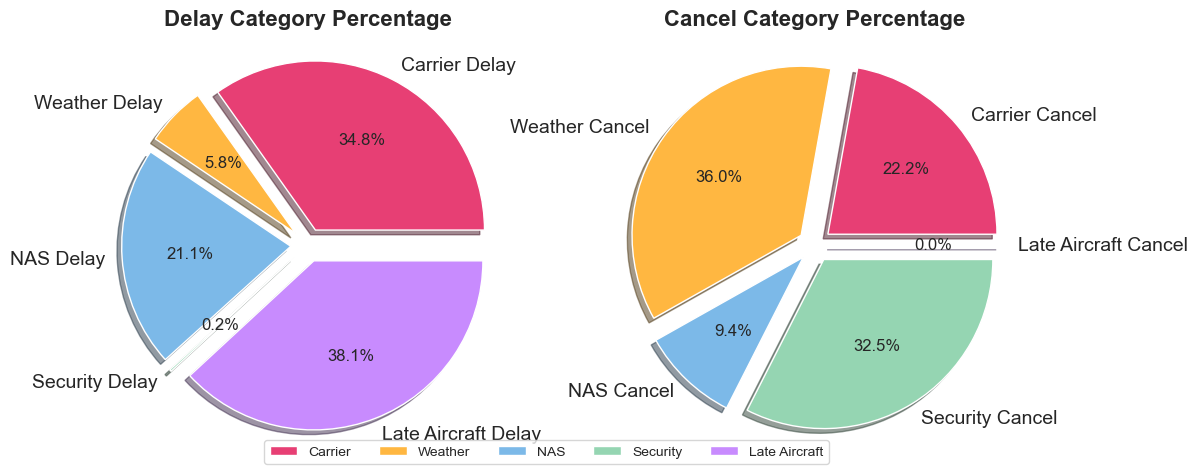

In [132]:
# Define a custom color palette
colors = ['#E73F74', '#FFB741', '#7CB9E8', '#95D5B2', '#C88BFE']

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Create the first pie chart using the custom color palette and a shadow effect
wedges1, labels1, autopct1 = ax1.pie(category_viz['Percent_of_Delay'], labels=['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay'], autopct='%.1f%%',explode=[.1,.1,.1,.1,.1], colors=colors, shadow=True)

# Set the title and legend for the first chart
ax1.set_title("Delay Category Percentage", fontsize=16, weight='bold')
# ax1.legend(labels=['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay'], loc='center', bbox_to_anchor=(1, 0.5))

# Set the aspect ratio to 'equal' to make the pie chart circular for the first chart
ax1.set_aspect('equal')

# Create the second pie chart
wedges2, labels2, autopct2 = ax2.pie(category_viz['Percent_of_Cancel'], labels=['Carrier Cancel','Weather Cancel','NAS Cancel','Security Cancel','Late Aircraft Cancel'], autopct='%.1f%%',explode=[.1,.1,.1,.1,.1],colors=colors, shadow=True)

# Set the title and legend for the second chart
ax2.set_title("Cancel Category Percentage", fontsize=16, weight='bold')
# ax2.legend(labels=total_cancel_category.index, loc='center', bbox_to_anchor=(0, 0.5))

# Set the aspect ratio to 'equal' to make the pie chart circular for the second chart
ax2.set_aspect('equal')

# Set the text size for the labels and percentages
label_size = 14
percentage_size = 12
for ax, labels, autopct in zip([ax1, ax2], [labels1, labels2], [autopct1, autopct2]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zorder(1)
    for label in labels:
        label.set_size(label_size)
    for percentage in autopct:
        percentage.set_size(percentage_size)

# Add a legend for both charts
fig.legend(labels=['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft'], loc='center', bbox_to_anchor=(0.5, 0.15), ncol=5)

# Show the plot
plt.show()



#### Airports

In [41]:
airport_viz

,Unnamed: 0,Airport_Code,Airport_City,Airport_State,Arr_Cancel_Count,Dep_Cancel_Count,Arr_Delay_Count,Dep_Delay_Count,Arr_Delay_Sum,Dep_Delay_Sum,...,Arr_NAS_Delay,Dep_NAS_Delay,Arr_NAS_Sum,Dep_NAS_Sum,Arr_Security_Cancel,Dep_Security_Cancel,Arr_Security_Delay,Dep_Security_Delay,Arr_Security_Sum,Dep_Security_Sum
0,0,ABY,Albany,GA,36.0,37.0,955,696,37037.0,42033.0,...,226.0,218.0,5156.0,4579.0,21.0,20.0,1.0,1.0,14.0,28.0
1,1,ATL,Atlanta,GA,22034.0,21710.0,353208,431582,13196243.0,13386669.0,...,91776.0,93001.0,2382867.0,2441570.0,10668.0,10718.0,616.0,652.0,23049.0,27821.0
2,2,MOB,Mobile,AL,614.0,652.0,7515,5583,288949.0,307524.0,...,1984.0,1849.0,38781.0,51781.0,166.0,156.0,4.0,13.0,119.0,178.0
3,3,BUF,Buffalo,NY,3566.0,3742.0,31552,26199,1323411.0,1276285.0,...,7912.0,9230.0,168909.0,343473.0,1114.0,1099.0,61.0,24.0,2219.0,737.0
4,4,DFW,Dallas/Fort Worth,TX,37683.0,36698.0,373561,381306,16603563.0,15307861.0,...,108794.0,104270.0,3365157.0,2353239.0,10108.0,10222.0,1139.0,705.0,25371.0,19096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,GCK,Garden City,KS,94.0,103.0,789,668,23985.0,32507.0,...,184.0,244.0,3644.0,5519.0,20.0,19.0,1.0,2.0,60.0,16.0
384,384,DBQ,Dubuque,IA,124.0,131.0,992,552,34978.0,29953.0,...,355.0,247.0,7320.0,7549.0,20.0,19.0,NaN,NaN,0.0,0.0
385,385,SPS,Wichita Falls,TX,225.0,224.0,1284,965,31394.0,41936.0,...,314.0,452.0,6012.0,9653.0,33.0,28.0,1.0,4.0,38.0,67.0
386,386,SWO,Stillwater,OK,89.0,91.0,721,440,20064.0,26472.0,...,147.0,198.0,3165.0,4965.0,23.0,21.0,NaN,2.0,0.0,30.0


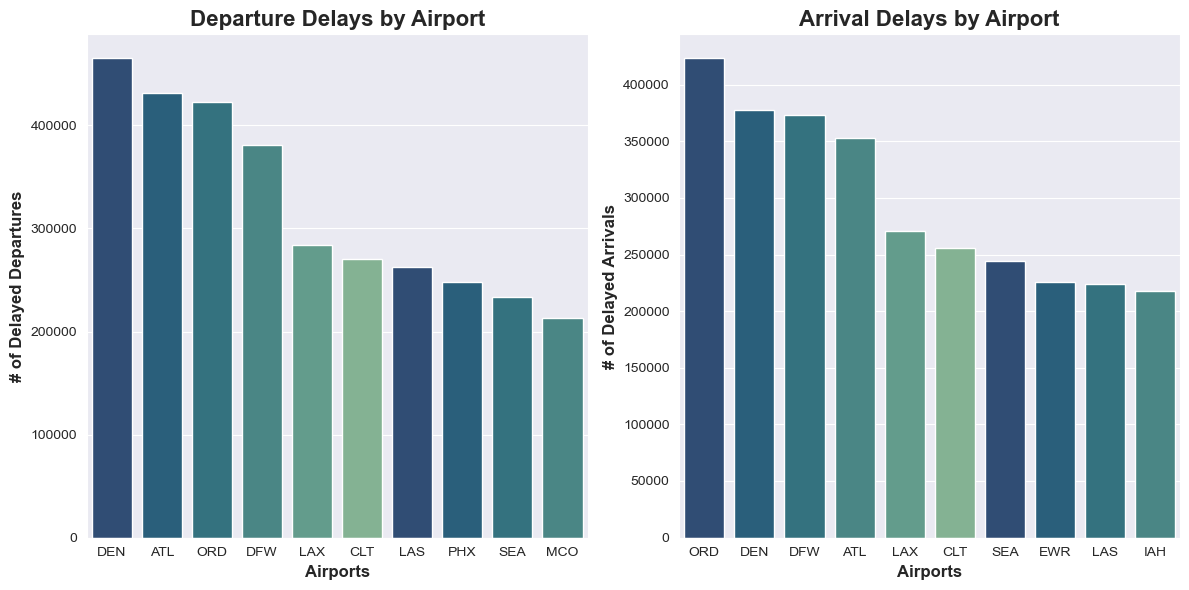

In [50]:

# Set the style to a cool theme
sns.set_style('darkgrid')

# Set the palette to "crest"
palette = sns.color_palette('crest_r')
sns.set_palette(palette)

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Create the first barplot
sns.barplot(x='Airport_Code', y='Dep_Delay_Count',data=airport_viz.sort_values(by='Dep_Delay_Count',ascending=False).head(10),ax=axes[0], palette=palette)
axes[0].set_xlabel('Airports', fontsize=12, weight='bold')
axes[0].set_ylabel('# of Delayed Departures', fontsize=12, weight='bold')
axes[0].set_title('Departure Delays by Airport', fontsize=16, weight='bold')

# Create the second barplot
sns.barplot(x='Airport_Code', y='Arr_Delay_Count',data=airport_viz.sort_values(by='Arr_Delay_Count',ascending=False).head(10), ax=axes[1], palette=palette)
axes[1].set_xlabel('Airports', fontsize=12, weight='bold')
axes[1].set_ylabel('# of Delayed Arrivals', fontsize=12, weight='bold')
axes[1].set_title('Arrival Delays by Airport', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()



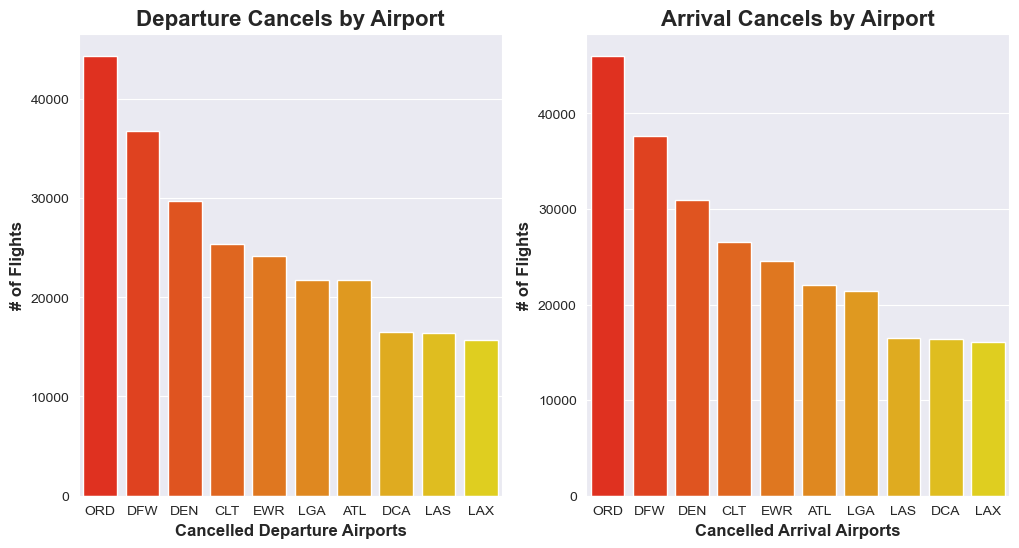

In [51]:
# Set the style 
sns.set_style('darkgrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2,figsize=(12, 6))

# Plot the bar chart with the custom color palette
sns.barplot(x='Airport_Code', y='Arr_Cancel_Count', data=airport_viz.sort_values(by='Arr_Cancel_Count',ascending=False).head(10), ax=axes[1], palette='autumn')
# Plot the bar chart with the custom color palette
sns.barplot(x='Airport_Code', y='Dep_Cancel_Count', data=airport_viz.sort_values(by='Dep_Cancel_Count',ascending=False).head(10), ax=axes[0], palette='autumn')
# Set the axis[0] labels and title
axes[1].set_xlabel('Cancelled Arrival Airports', fontsize=12, weight='bold')
axes[1].set_ylabel('# of Flights', fontsize=12, weight='bold')
axes[1].set_title('Arrival Cancels by Airport', fontsize=16, weight='bold')
# Set the axis[1] labels and title
axes[0].set_xlabel('Cancelled Departure Airports', fontsize=12, weight='bold')
axes[0].set_ylabel('# of Flights', fontsize=12, weight='bold')
axes[0].set_title('Departure Cancels by Airport', fontsize=16, weight='bold')



for ax in axes:
    # Set the tick label font size
    ax.tick_params(axis='both', labelsize=10)

# Show the plot
plt.show()

In [141]:
airline_viz

,Airline_Code,Airline_Name,Total_Flight_Count,Cancel_Count,Delay_Count,Arr_Delay_Sum,Dep_Delay_Sum,Total_Delay_Avg,Arr_Delay_Avg,Dep_Delay_Avg,...,Weather_Delay_Sum,Weather_Delay_Avg,NAS_Cancel_Count,NAS_Delay_Count,NAS_Delay_Sum,NAS_Delay_Avg,Security_Cancel_Count,Security_Delay_Count,Security_Delay_Sum,Security_Delay_Avg
0,02Q,Titan Airways,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04Q,Tradewind Aviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,05Q,"Comlux Aviation, AG",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06Q,Master Top Linhas Aereas Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07Q,Flair Airlines Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,ZW,Air Wisconsin Airlines Corp,380202.0,14092.0,125179.0,5836745.0,5583145.0,30.036375,46.62719,44.601291,...,255219.0,53.303885,1524.0,35768.0,1148359.0,32.105765,3115.0,4.0,266.0,66.5
1567,ZX,Air Georgian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,ZX (1),Airbc Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1569,ZY,Atlantic Gulf Airlines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Airlines

In [142]:
airline_viz['Delay_Percentage']= airline_viz['Delay_Count']/airline_viz['Total_Flight_Count']
airline_viz['Cancel_Percentage']= airline_viz['Cancel_Count']/airline_viz['Total_Flight_Count']

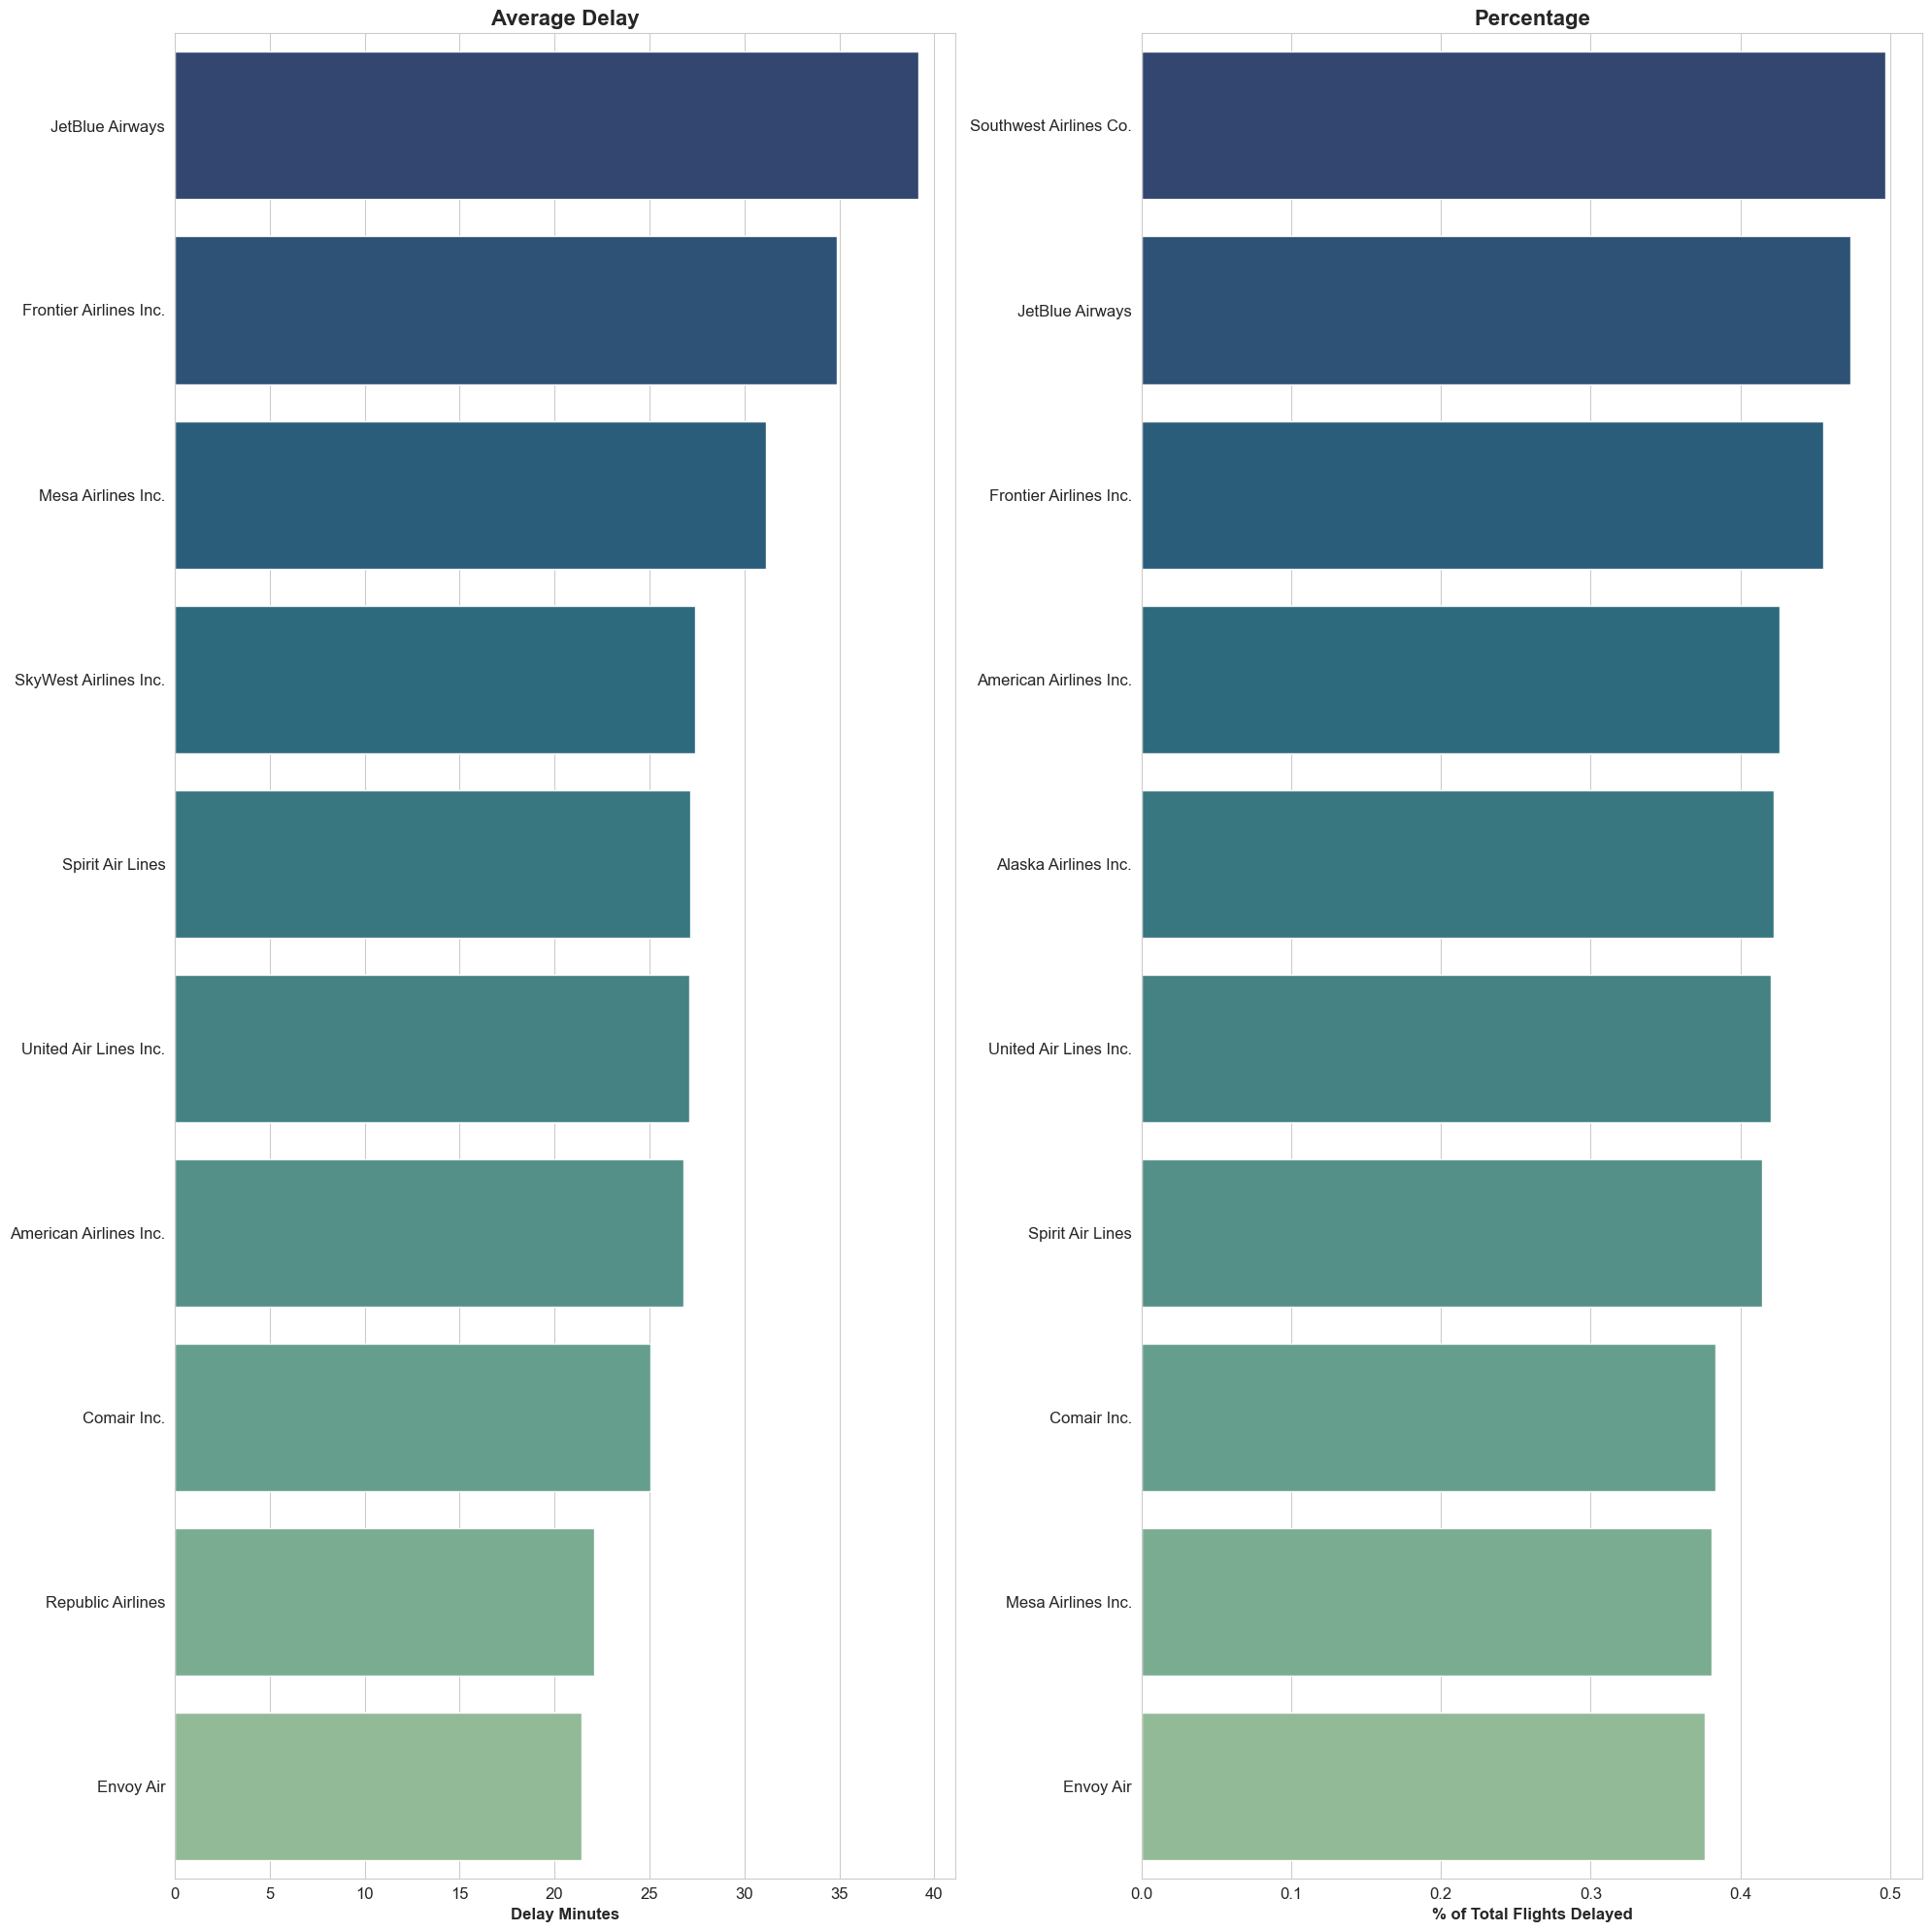

In [161]:
# Set the style to a Seaborn style
sns.set_style('whitegrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1]})

# Create the first horizontal bar plot using Seaborn
sns.barplot(
    x='Total_Delay_Avg', 
    y='Airline_Name', 
    data=airline_viz.loc[airline_viz['Total_Flight_Count']>500000].sort_values(by='Total_Delay_Avg',
                                                                                ascending=False).head(10),
    palette='crest_r', 
    ax=axes[0])

# # Invert the y-axis to show airlines from top to bottom
# axes[0].invert_xaxis()

# Set the axis labels and title for the first plot
axes[0].set_xlabel('Delay Minutes', fontsize=12, weight='bold')
axes[0].set_ylabel('')
axes[0].set_title('Average Delay', fontsize=16, weight='bold')
axes[0].set_xticklabels()
# Create the second horizontal bar plot using Seaborn
sns.barplot(
    x='Delay_Percentage', 
    y='Airline_Name', 
    data=airline_viz.loc[airline_viz['Total_Flight_Count']>500000].sort_values(by='Delay_Percentage',ascending=False).head(10), 
    palette='crest_r', 
    ax=axes[1])

# Invert the y-axis to show airlines from top to bottom
# axes[1].invert_yaxis()

# Set the axis labels and title for the second plot
axes[1].set_xlabel('% of Total Flights Delayed', fontsize=12, weight='bold')
axes[1].set_ylabel('')
axes[1].set_title('Percentage', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

# Align the y-axis labels to the center of the plot
fig.align_ylabels()

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()


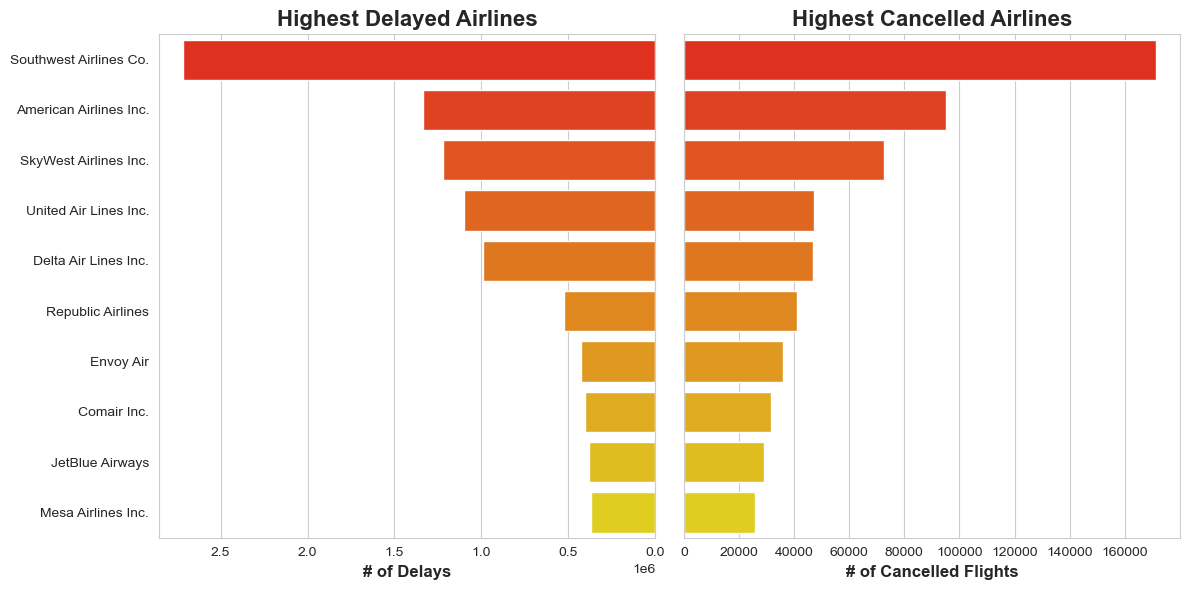

In [53]:
# Set the style to a Seaborn style
sns.set_style('whitegrid')

# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Create the first horizontal bar plot using Seaborn
sns.barplot(x='Delay_Count', y='Airline_Name', data=airline_viz.sort_values(by='Delay_Count',ascending=False).head(10), palette='autumn', ax=axes[0])

# Invert the y-axis to show airlines from top to bottom
axes[0].invert_xaxis()

# Set the axis labels and title for the first plot
axes[0].set_xlabel('# of Delays', fontsize=12, weight='bold')
axes[0].set_ylabel('')
axes[0].set_title('Highest Delayed Airlines', fontsize=16, weight='bold')

# Create the second horizontal bar plot using Seaborn
sns.barplot(x='Cancel_Count', y='Airline_Name', data=airline_viz.sort_values(by='Cancel_Count',ascending=False).head(10), palette='autumn', ax=axes[1])

# Invert the y-axis to show airlines from top to bottom
# axes[1].invert_yaxis()

# Set the axis labels and title for the second plot
axes[1].set_xlabel('# of Cancelled Flights', fontsize=12, weight='bold')
axes[1].set_ylabel('')
axes[1].set_title('Highest Cancelled Airlines', fontsize=16, weight='bold')

# Set the tick label font size for both plots
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)

# Align the y-axis labels to the center of the plot
fig.align_ylabels()

# Adjust the layout to prevent overlapping labels
fig.tight_layout()

# Show the plot
plt.show()


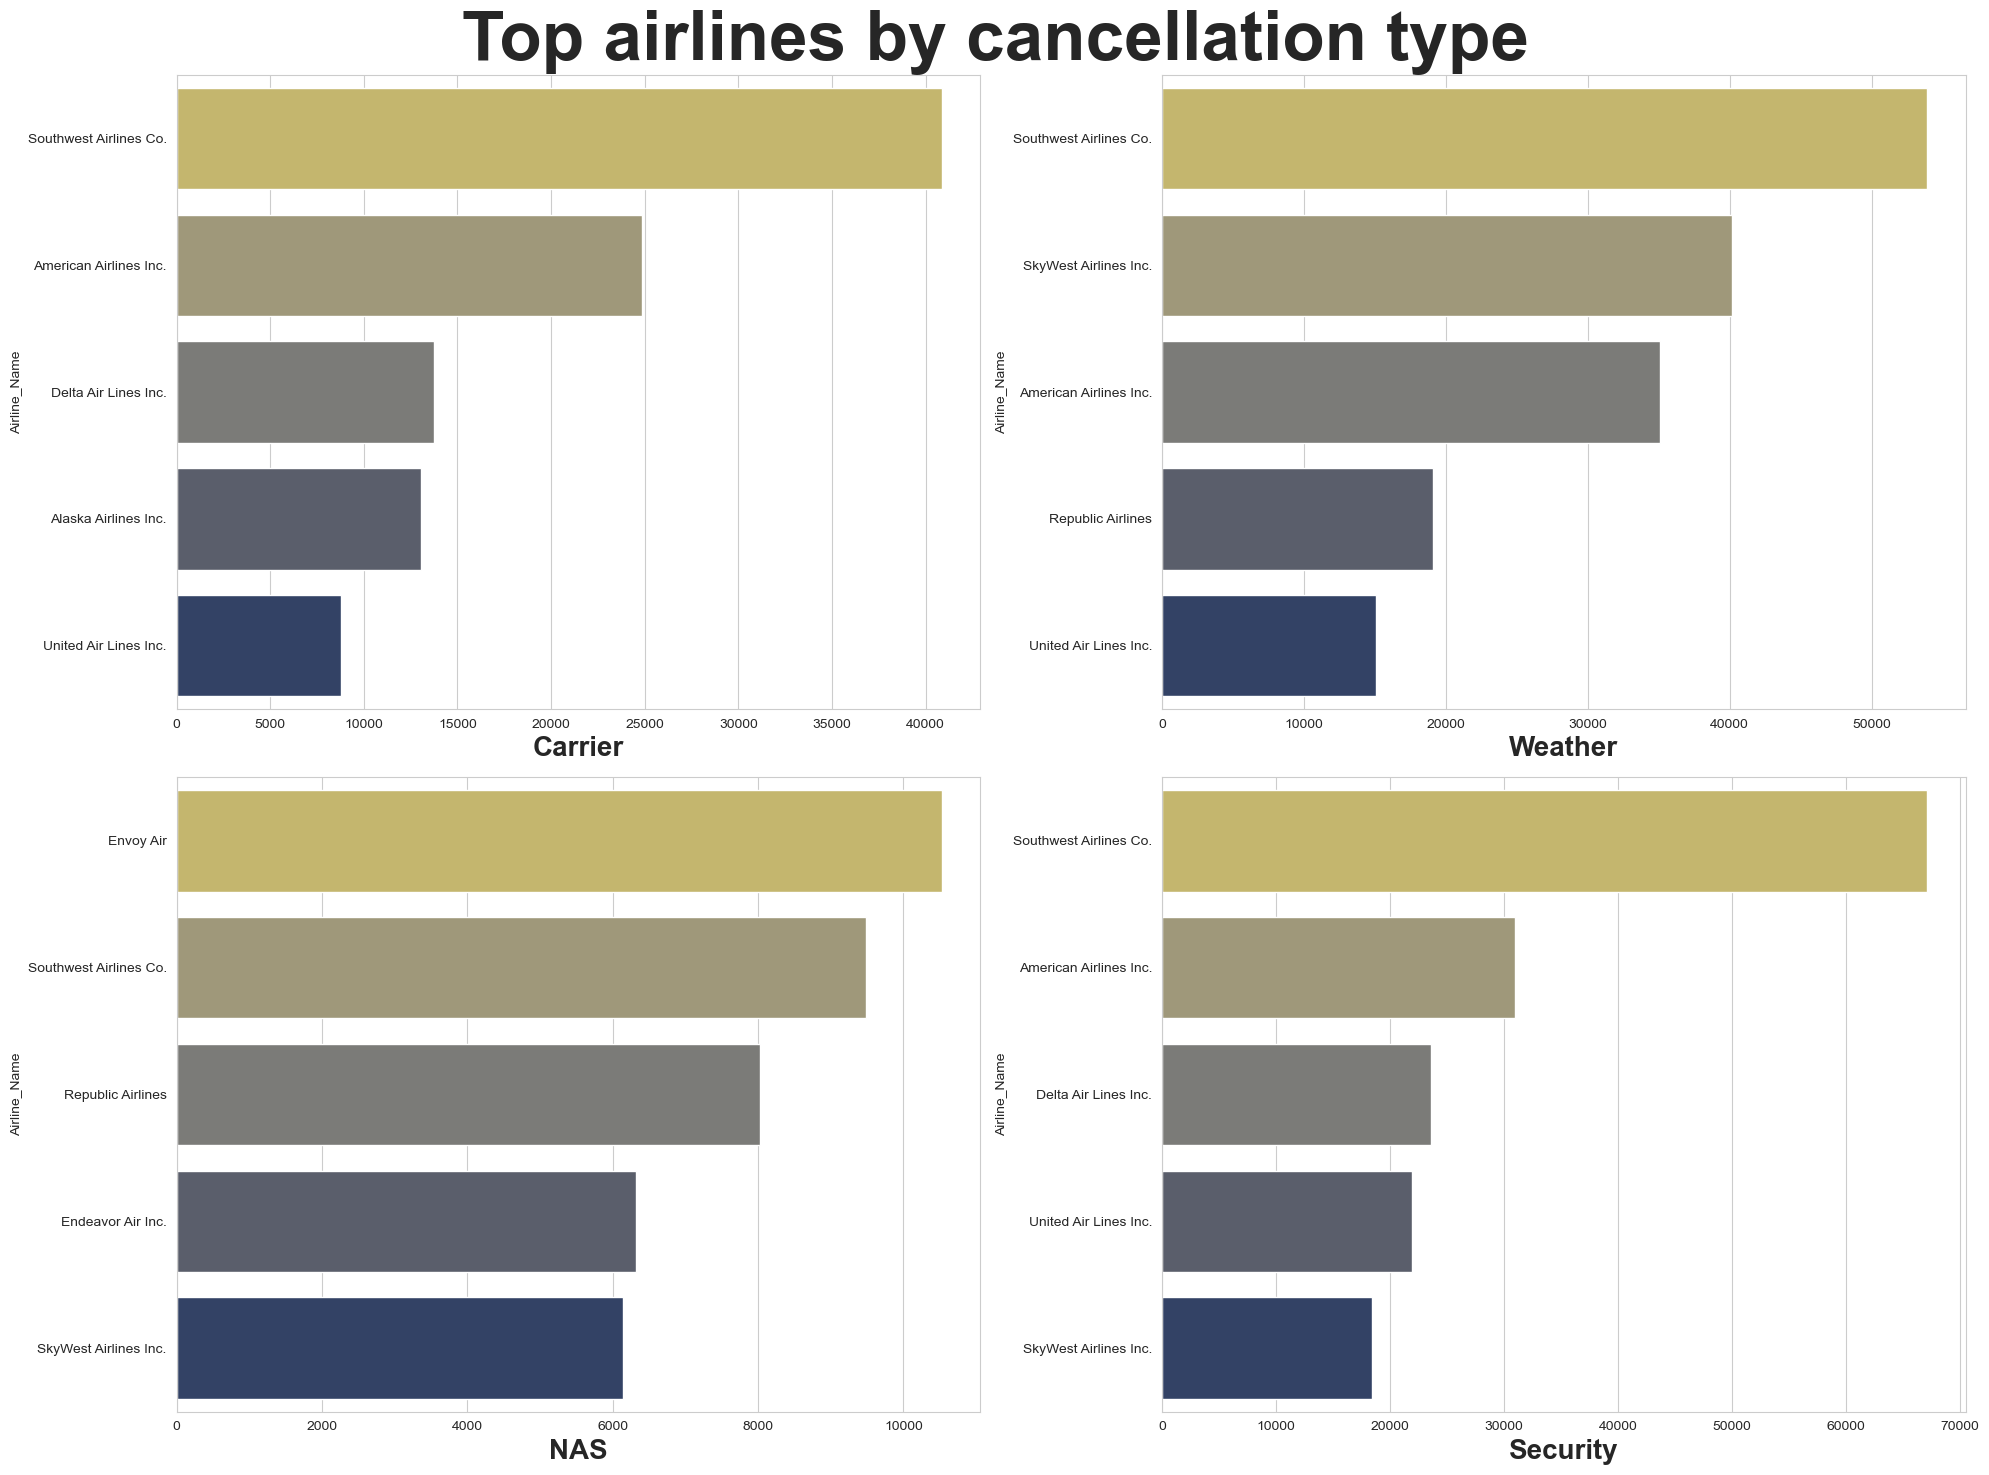

In [54]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

plt.suptitle('Top airlines by cancellation type',weight='bold',fontsize='50')

sns.barplot(y='Airline_Name',x='Carrier_Cancel_Count',data=airline_viz.sort_values('Carrier_Cancel_Count',ascending=False).head(5),ax=axes[0,0], palette='cividis_r') 

axes[0,0].set_xlabel('Carrier',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='Weather_Cancel_Count',data=airline_viz.sort_values('Weather_Cancel_Count',ascending=False).head(5),ax=axes[0,1], palette='cividis_r') 

axes[0,1].set_xlabel('Weather',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='NAS_Cancel_Count',data=airline_viz.sort_values('NAS_Cancel_Count',ascending=False).head(5),ax=axes[1,0], palette='cividis_r') 

axes[1,0].set_xlabel('NAS',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='Security_Cancel_Count',data=airline_viz.sort_values('Security_Cancel_Count',ascending=False).head(5),ax=axes[1,1], palette='cividis_r') 

axes[1,1].set_xlabel('Security',fontsize='20',weight='bold')

plt.tight_layout()

plt.show()


In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

plt.suptitle('Top airlines by cancellation type',weight='bold',fontsize='50')

sns.barplot(y='Airline_Name',x='Carrier_Cancel_Count',data=airline_viz.sort_values('Carrier_Cancel_Count',ascending=False).head(5),ax=axes[0,0], palette='cividis_r') 

axes[0,0].set_xlabel('Carrier',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='Weather_Cancel_Count',data=airline_viz.sort_values('Weather_Cancel_Count',ascending=False).head(5),ax=axes[0,1], palette='cividis_r') 

axes[0,1].set_xlabel('Weather',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='NAS_Cancel_Count',data=airline_viz.sort_values('NAS_Cancel_Count',ascending=False).head(5),ax=axes[1,0], palette='cividis_r') 

axes[1,0].set_xlabel('NAS',fontsize='20',weight='bold')

sns.barplot(y='Airline_Name',x='Security_Cancel_Count',data=airline_viz.sort_values('Security_Cancel_Count',ascending=False).head(5),ax=axes[1,1], palette='cividis_r') 

axes[1,1].set_xlabel('Security',fontsize='20',weight='bold')

plt.tight_layout()

plt.show()